<a href="https://colab.research.google.com/github/anasnafis77/Deteksi-Glaukoma/blob/main/Glaucoma_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import random
import tensorflow as tf
from ipywidgets import interact
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [3]:
def index_shuffle(f, random_state=4):
  ix_dr_gl = np.array(list(range(0, 32)))
  ix_dr_n = np.array(list(range(32, 50)))
  ix_re_gl = np.array(list(range(50, 90)))
  ix_re_n = np.array(list(range(90, 450)))
  
  random.Random(random_state).shuffle(ix_dr_gl)
  random.Random(random_state).shuffle(ix_dr_n)
  random.Random(random_state).shuffle(ix_re_gl)
  random.Random(random_state).shuffle(ix_re_n)
  # test_size = 1/k
  # [x*test_size for x in list(range(0, 33, test_size*32))]
  dr_gl = np.array([0, 6, 12, 18, 25, 32]) # portion of each fold for drishti-glaucoma data
  dr_n = np.array([0, 3, 6, 10, 14, 18]) # portion of each fold for drishti-normal data
  re_gl = np.array([0, 8, 16, 24, 32, 40]) # portion of each fold for refuge-glaucoma data
  re_n = np.array([0, 72, 144, 216, 288, 360]) # portion of each fold for refuge-normal data
  
  i = f - 1
  # meta-index for train data
  tr_dr_gl = list(range(dr_gl[i])) + list(range(dr_gl[i+1], 32))
  tr_dr_n = list(range(dr_n[i])) + list(range(dr_n[i+1], 18))
  tr_re_gl = list(range(re_gl[i])) + list(range(re_gl[i+1], 40))
  tr_re_n = list(range(re_n[i])) + list(range(re_n[i+1], 360))

  # meta-index for test data
  te_dr_gl = list(range(dr_gl[i], dr_gl[i+1])) 
  te_dr_n = list(range(dr_n[i], dr_n[i+1]))
  te_re_gl = list(range(re_gl[i], re_gl[i+1]))
  te_re_n = list(range(re_n[i], re_n[i+1]))

  ix_train = np.concatenate((ix_dr_gl[tr_dr_gl], ix_dr_n[tr_dr_n],
                               ix_re_gl[tr_re_gl], ix_re_n[tr_re_n]))
  ix_test = np.concatenate((ix_dr_gl[te_dr_gl], ix_dr_n[te_dr_n],
                              ix_re_gl[te_re_gl],  ix_re_n[te_re_n]))
  
  random.Random(random_state).shuffle(ix_train)
  random.Random(random_state).shuffle(ix_test)


  return ix_train, ix_test

# Data Acquisition

In [4]:
path = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/'

In [26]:
df = pd.read_json(path+'dataframe_new.json')
result = pd.read_json(path+'result.json')

In [6]:
gl_ix = df.index[df['tag']=='Glaucoma'].tolist()
n_ix = df.index[df['tag']=='Normal'].tolist()
dr_gl_ix = [x for x in gl_ix if x < 50]
re_gl_ix = [x for x in gl_ix if x >= 50]
dr_n_ix = [x for x in n_ix if x < 50]
re_n_ix = [x for x in n_ix if x >= 50]
print(len(dr_gl_ix)+len(dr_n_ix))
print(len(re_gl_ix)+len(re_n_ix))

50
400


In [7]:
def CDR_calc(OD_mask, OC_mask):
  try:
    c_OD,_ = cv2.findContours(OD_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    p_OD = cv2.approxPolyDP(c_OD[0], 3, True)
    c_OC,_ = cv2.findContours(OC_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    p_OC = cv2.approxPolyDP(c_OC[0], 3, True)
    x_OD, y_OD, hor_OD, ver_OD = cv2.boundingRect(p_OD)
    x_OC, y_OC, hor_OC, ver_OC = cv2.boundingRect(p_OC)
    

    VCDR = ver_OC/ver_OD # vertical CDR
    HCDR = hor_OC/ hor_OD # Horizontal CDR
    ACDR = np.sum(OC_mask == 255)/ np.sum(OD_mask == 255) # Area CDR


  except:
    VCDR = float("nan")
    HCDR = float("nan")
    ACDR = float("nan")
  
  return VCDR, HCDR, ACDR

In [ ]:
# vertical CDR perhitungan mandiri pada mask gt
VCDR_gtm = []
VCDR_seg = []
VCDR_gtm = []
VCDR_seg = []
HCDR_gtm = []
HCDR_seg = []
ACDR_gtm = []
ACDR_seg = []
nan_ix = []
for i in tqdm(range(len(df))):
  OD_gt = cv2.imread(df['path_OD_png'][i], 0)
  OC_gt = cv2.imread(df['path_OC_png'][i], 0)
  OD_seg = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OD_{}.png'.format(i+1), 0)
  OC_seg = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OC_{}.png'.format(i+1), 0)
  VCDR_gt, HCDR_gt, ACDR_gt = CDR_calc(OD_gt, OC_gt)
  VCDR_sg, HCDR_sg, ACDR_sg = CDR_calc(OD_seg, OC_seg)

  VCDR_gtm.append(VCDR_gt)
  VCDR_seg.append(VCDR_sg)
  HCDR_gtm.append(HCDR_gt)
  HCDR_seg.append(HCDR_sg)
  ACDR_gtm.append(ACDR_gt)
  ACDR_seg.append(ACDR_sg)
  if np.isnan(VCDR_sg):
    nan_ix.append(i)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
inf_df = pd.DataFrame({'VCDR Gold': VCDR_gtn, 'VCDR': VCDR_seg, 'HCDR': HCDR_seg, 
                       'ACDR': ACDR_seg, 'VCDR GT': VCDR_gtm, 'HCDR GT': HCDR_gtm,
                       'ACDR GT': ACDR_gtm, 'tag': df['tag'].tolist()})
inf_df.to_csv('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/inference_data.csv')
inf_df.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/inference_data.json')

In [8]:
inf_df = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/inference_data.json')

# Data Exploration

In [9]:
def make_linear(X, Y):
  linear_regressor = LinearRegression()  # create object for the class
  linear_regressor.fit(X, Y)  # perform linear regression
  Y_pred = linear_regressor.predict(X)  # make predictions
  return Y_pred

def r_squared(X, Y):
  X = X.squeeze()
  Y = Y.squeeze()
  correlation_matrix = np.corrcoef(X, Y)
  correlation_xy = correlation_matrix[0,1]
  r_square = correlation_xy**2
  return r_square

Hubungan antara vairabel

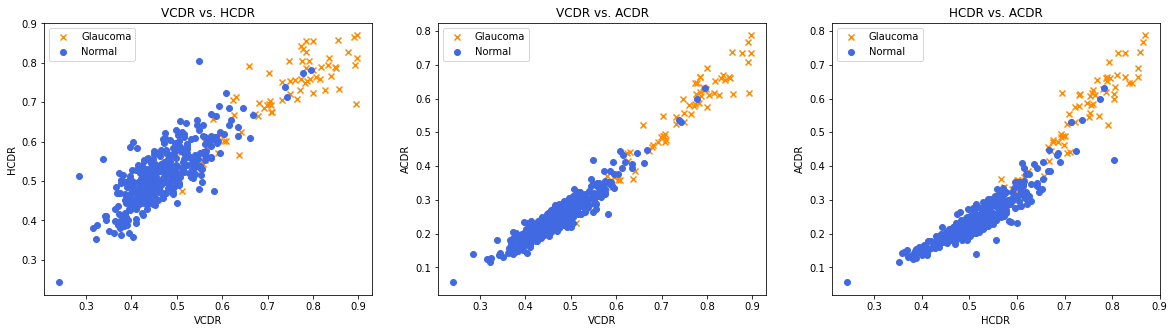

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(x=inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR GT'],
            marker='x', color ='darkorange', label='Glaucoma')
ax[0].scatter(x=inf_df.loc[inf_df['tag']=='Normal']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Normal']['HCDR GT'],
            marker='o', color ='royalblue', label='Normal')
ax[0].set_title('VCDR vs. HCDR')
ax[0].set_xlabel('VCDR')
ax[0].set_ylabel('HCDR')
ax[0].legend()
ax[1].scatter(x=inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR GT'],
            marker='x', color ='darkorange', label='Glaucoma')
ax[1].scatter(x=inf_df.loc[inf_df['tag']=='Normal']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Normal']['ACDR GT'],
            marker='o', color ='royalblue', label='Normal')
ax[1].set_title('VCDR vs. ACDR')
ax[1].set_xlabel('VCDR')
ax[1].set_ylabel('ACDR')
ax[1].legend()
ax[2].scatter(x=inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR GT'],
            marker='x', color ='darkorange', label='Glaucoma')
ax[2].scatter(x=inf_df.loc[inf_df['tag']=='Normal']['HCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Normal']['ACDR GT'],
            marker='o', color ='royalblue', label='Normal')
ax[2].set_title('HCDR vs. ACDR')
ax[2].set_xlabel('HCDR')
ax[2].set_ylabel('ACDR')
ax[2].legend()
plt.show()

In [24]:
vcdr_error = inf_df['VCDR GT']-inf_df['VCDR']
hcdr_error = inf_df['HCDR GT']-inf_df['HCDR']
acdr_error = inf_df['ACDR GT']-inf_df['ACDR']
ix_error_vcdr = vcdr_error.index[(vcdr_error > (np.mean(vcdr_error) + np.std(vcdr_error)))|( vcdr_error < (np.mean(vcdr_error) - np.std(vcdr_error)))]
print(np.mean(vcdr_error) + np.std(vcdr_error))
print(np.mean(vcdr_error) - np.std(vcdr_error))

0.05093027829120141
-0.03985866151831253


In [23]:
len(ix_error_vcdr)

113

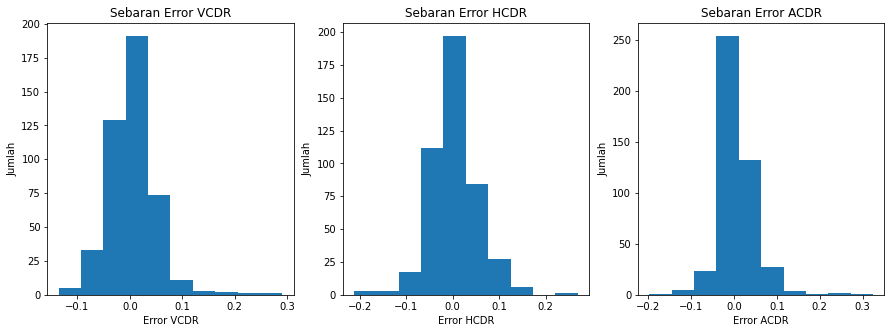

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.hist(vcdr_error)
plt.ylabel('Jumlah')
plt.xlabel('Error VCDR')
plt.title('Sebaran Error VCDR')
plt.subplot(1,3,2)
plt.hist(hcdr_error)
plt.ylabel('Jumlah')
plt.xlabel('Error HCDR')
plt.title('Sebaran Error HCDR')
plt.subplot(1,3,3)
plt.hist(acdr_error)
plt.ylabel('Jumlah')
plt.xlabel('Error ACDR')
plt.title('Sebaran Error ACDR')
plt.show()

In [25]:
@interact(i=ix_error_vcdr)
def show_groundtruth(i=ix_error_vcdr[0]):
  
  img = cv2.imread(df['path_OD'][i], 0)
  ROI = 
  mask_OD_gt = cv2.imread(df['path_OD_png'][i], 0)
  mask_OC_gt = cv2.imread(df['path_OC_png'][i], 0)
  mask_OD = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OD_{}.png'.format(i+1), 0)
  mask_OC = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OC_{}.png'.format(i+1), 0)
  
  h, w = mask_OD_gt.shape[:2]
  mask_OD_gt_show = np.zeros((h, w, 3), np.uint8)
  mask_OD_show = np.zeros((h, w, 3), np.uint8)
  mask_OC_gt_show = np.zeros((h, w, 3), np.uint8)
  mask_OC_show = np.zeros((h, w, 3), np.uint8)

  mask_OD_gt_show[mask_OD_gt==255] = (255, 0, 0)
  mask_OD_show[mask_OD==255] = (0, 0, 255)

  mask_OC_gt_show[mask_OC_gt==255] = (255, 0, 0)
  mask_OC_show[mask_OC==255] = (0, 0, 255)

  DSC_OD = np.sum(mask_OD[mask_OD_gt==255])*2.0/(np.sum(mask_OD) + np.sum(mask_OD_gt))
  DSC_OC = np.sum(mask_OC[mask_OC_gt==255])*2.0/(np.sum(mask_OC) + np.sum(mask_OC_gt))

  plt.figure(figsize=(10, 10))
  plt.subplot(121),
  plt.imshow(mask_OD_gt_show, interpolation='none')
  plt.imshow(mask_OD_show, interpolation='none', alpha=0.35)
  plt.text(100, 100, 'DSC: {:.3f}'.format(DSC_OD), size='small', color='w')
  plt.subplot(122),
  plt.imshow(mask_OC_gt_show, interpolation='none')
  plt.imshow(mask_OC_show, interpolation='none', alpha=0.35)
  plt.text(100, 100, 'DSC: {:.3f}'.format(DSC_OC), size ='small', color='w')
  plt.show()

interactive(children=(Dropdown(description='i', options=(6, 7, 8, 22, 25, 26, 29, 33, 42, 43, 45, 48, 52, 53, …

In [ ]:
@interact(i=ix_error)
def show_groundtruth(i=ix_error[0]):
  
  mask_OD_gt = cv2.imread(df['path_OD_png'][i], 0)
  mask_OC_gt = cv2.imread(df['path_OC_png'][i], 0)
  mask_OD = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OD_{}.png'.format(i+1), 0)
  mask_OC = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OC_{}.png'.format(i+1), 0)
  h, w = mask_OD_gt.shape[:2]
  mask_OD_gt_show = np.zeros((h, w, 3), np.uint8)
  mask_OD_show = np.zeros((h, w, 3), np.uint8)
  mask_OC_gt_show = np.zeros((h, w, 3), np.uint8)
  mask_OC_show = np.zeros((h, w, 3), np.uint8)

  mask_OD_gt_show[mask_OD_gt==255] = (255, 0, 0)
  mask_OD_show[mask_OD==255] = (0, 0, 255)

  mask_OC_gt_show[mask_OC_gt==255] = (255, 0, 0)
  mask_OC_show[mask_OC==255] = (0, 0, 255)

  DSC_OD = np.sum(mask_OD[mask_OD_gt==255])*2.0/(np.sum(mask_OD) + np.sum(mask_OD_gt))
  DSC_OC = np.sum(mask_OC[mask_OC_gt==255])*2.0/(np.sum(mask_OC) + np.sum(mask_OC_gt))

  print('VCDR: ', inf_df['VCDR'][i])
  print('VCDR GT: ', inf_df['VCDR GT'][i])
  print(abs_error[i])
  plt.figure(figsize=(10, 10))
  plt.subplot(121),
  plt.imshow(mask_OD_gt_show, interpolation='none')
  plt.imshow(mask_OD_show, interpolation='none', alpha=0.35)
  plt.text(100, 100, 'DSC: {:.3f}'.format(DSC_OD), size='small', color='w')
  plt.subplot(122),
  plt.imshow(mask_OC_gt_show, interpolation='none')
  plt.imshow(mask_OC_show, interpolation='none', alpha=0.35)
  plt.text(100, 100, 'DSC: {:.3f}'.format(DSC_OC), size ='small', color='w')
  plt.show()

interactive(children=(Dropdown(description='i', options=(15, 17, 46), value=15), Output()), _dom_classes=('wid…

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

Text(0.5, 1.0, 'Boxplot ACDR GT')

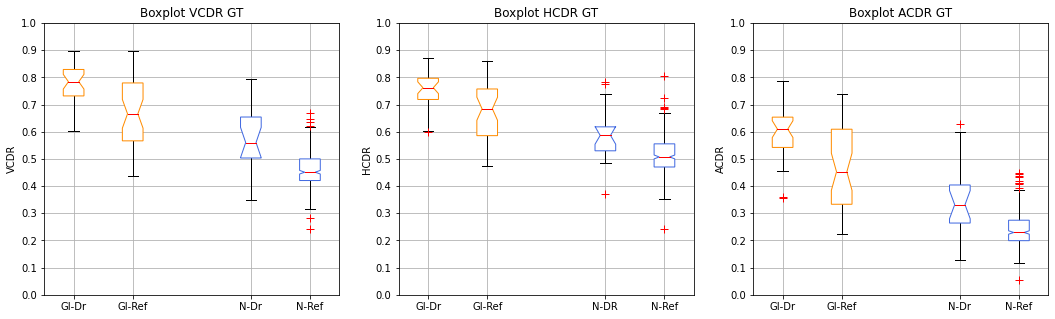

In [ ]:
plt.figure(figsize=(18, 5))
flierprops = dict(marker='+', markerfacecolor='g', markersize=8,
                  linestyle='none', markeredgecolor='r')
glprops = dict(color='darkorange', facecolor='w')
nprops = dict(color='royalblue',facecolor='w')
medianprops=dict(color='r')
data_VCDR_gl= [inf_df['VCDR GT'][dr_gl_ix], inf_df['VCDR GT'][re_gl_ix]]
data_VCDR_n = [inf_df['VCDR GT'][dr_n_ix], inf_df['VCDR GT'][re_n_ix]]

data_HCDR_gl= [inf_df['HCDR GT'][dr_gl_ix], inf_df['HCDR GT'][re_gl_ix]]
data_HCDR_n = [inf_df['HCDR GT'][dr_n_ix], inf_df['HCDR GT'][re_n_ix]]

data_ACDR_gl = [inf_df['ACDR GT'][dr_gl_ix], inf_df['ACDR GT'][re_gl_ix]]
data_ACDR_n  = [inf_df['ACDR GT'][dr_n_ix], inf_df['ACDR GT'][re_n_ix]]

plt.subplot(1,3,1), 
plt.boxplot(data_VCDR_gl, notch=True, positions=[1, 2], widths=0.35, flierprops=flierprops, boxprops=glprops, medianprops=medianprops, patch_artist=True)
plt.boxplot(data_VCDR_n, notch=True, positions=[4, 5], widths=0.35,flierprops=flierprops, boxprops=nprops, medianprops=medianprops, patch_artist=True)
plt.grid()
plt.yticks(ticks=[x*0.1 for x in range(0, 11)])
plt.ylabel('VCDR')
# plt.axhline(0.52, color = 'r', linestyle = '--', label = 'threshold')
plt.xticks([1, 2, 4, 5], labels=['Gl-Dr', 'Gl-Ref', 
                                 'N-Dr', 'N-Ref'])
plt.title('Boxplot VCDR GT')

plt.subplot(1,3,2)
plt.boxplot(data_HCDR_gl, notch=True, positions=[1, 2], widths=0.35,flierprops=flierprops, boxprops=glprops, medianprops=medianprops, patch_artist=True)
plt.boxplot(data_HCDR_n, notch=True, positions=[4, 5], widths=0.35,flierprops=flierprops, boxprops=nprops, medianprops=medianprops, patch_artist=True)
plt.grid()
plt.yticks(ticks=[x*0.1 for x in range(0, 11)])
plt.ylabel('HCDR')
# plt.axhline(0.52, color = 'r', linestyle = '--', label = 'threshold')
plt.xticks([1, 2, 4, 5], labels=['Gl-Dr', 'Gl-Ref', 
                                 'N-DR', 'N-Ref'])
plt.title('Boxplot HCDR GT')

plt.subplot(1,3,3), 
plt.boxplot(data_ACDR_gl, notch=True, positions=[1, 2], widths=0.35, flierprops=flierprops, boxprops=glprops, medianprops=medianprops, patch_artist=True)
plt.boxplot(data_ACDR_n, notch=True, positions=[4, 5], widths=0.35, flierprops=flierprops, boxprops=nprops, medianprops=medianprops, patch_artist=True)
plt.grid()
plt.yticks(ticks=[x*0.1 for x in range(0, 11)])
plt.ylabel('ACDR')
# plt.axhline(0.52, color = 'r', linestyle = '--', label = 'threshold')
plt.xticks([1, 2, 4, 5], labels=['Gl-Dr', 'Gl-Ref', 
                                 'N-Dr', 'N-Ref'])

plt.title('Boxplot ACDR GT')

**VCDR Analysis**

Absolute error in all cases: 0.00498
Absolute error in glaucoma cases: 0.00541
Absolute error in normal cases: 0.00473


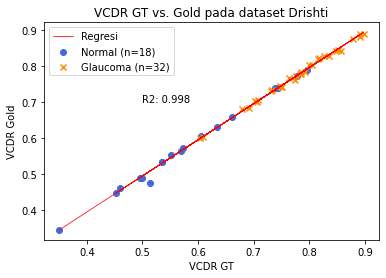

In [ ]:
abs_e = np.sum(abs(inf_df['VCDR Gold'][:50]-inf_df['VCDR GT'][:50]))/ 50
xo = inf_df['VCDR GT'][dr_n_ix]
yo = inf_df['VCDR Gold'][dr_n_ix]
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df['VCDR GT'][dr_gl_ix]
yi = inf_df['VCDR Gold'][dr_gl_ix]
abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['VCDR GT'][:50].to_numpy().reshape(-1, 1)
y = inf_df['VCDR Gold'][:50].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))


plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('VCDR Gold')
plt.xlabel('VCDR GT')
plt.title('VCDR GT vs. Gold pada dataset Drishti')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.04153
Absolute error in glaucoma cases: 0.03707
Absolute error in normal cases: 0.04404


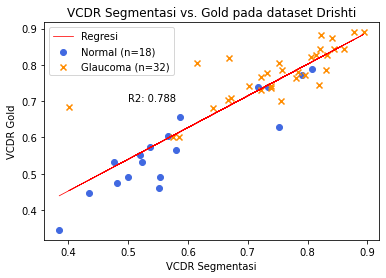

In [ ]:
abs_e = np.sum(abs(inf_df['VCDR Gold'][:50]-inf_df['VCDR'][:50]))/ 50
xo = inf_df['VCDR'][dr_n_ix]
yo = inf_df['VCDR Gold'][dr_n_ix]
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df['VCDR'][dr_gl_ix]
yi = inf_df['VCDR Gold'][dr_gl_ix]
abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['VCDR'][:50].to_numpy().reshape(-1, 1)
y = inf_df['VCDR Gold'][:50].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))


plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('VCDR Gold')
plt.xlabel('VCDR Segmentasi')
plt.title('VCDR Segmentasi vs. Gold pada dataset Drishti')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.04226
Absolute error in glaucoma cases: 0.03699
Absolute error in normal cases: 0.04522


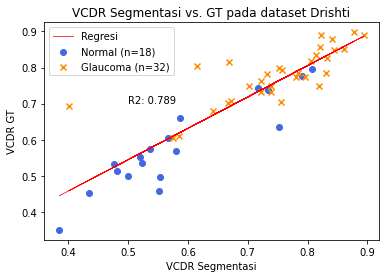

In [ ]:
abs_e = np.sum(abs(inf_df['VCDR GT'][:50]-inf_df['VCDR'][:50]))/ 50
xo = inf_df['VCDR'][dr_n_ix]
yo = inf_df['VCDR GT'][dr_n_ix]
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df['VCDR'][dr_gl_ix]
yi = inf_df['VCDR GT'][dr_gl_ix]
abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['VCDR'][:50].to_numpy().reshape(-1, 1)
y = inf_df['VCDR GT'][:50].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))


plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('VCDR GT')
plt.xlabel('VCDR Segmentasi')
plt.title('VCDR Segmentasi vs. GT pada dataset Drishti')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.04951
Absolute error in glaucoma cases: 0.04837
Absolute error in normal cases: 0.05014


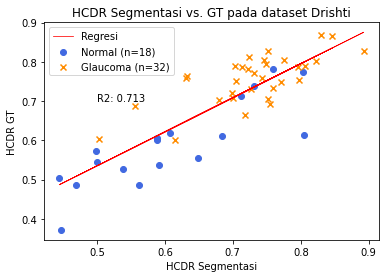

In [ ]:
abs_e = np.sum(abs(inf_df['HCDR GT'][:50]-inf_df['HCDR'][:50]))/ 50
xo = inf_df['HCDR'][dr_n_ix]
yo = inf_df['HCDR GT'][dr_n_ix]
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df['HCDR'][dr_gl_ix]
yi = inf_df['HCDR GT'][dr_gl_ix]
abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['HCDR'][:50].to_numpy().reshape(-1, 1)
y = inf_df['HCDR GT'][:50].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))


plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('HCDR GT')
plt.xlabel('HCDR Segmentasi')
plt.title('HCDR Segmentasi vs. GT pada dataset Drishti')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.04810
Absolute error in glaucoma cases: 0.03554
Absolute error in normal cases: 0.05516


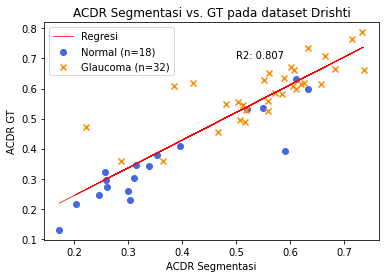

In [ ]:
abs_e = np.sum(abs(inf_df['ACDR GT'][:50]-inf_df['ACDR'][:50]))/ 50
xo = inf_df['ACDR'][dr_n_ix]
yo = inf_df['ACDR GT'][dr_n_ix]
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df['ACDR'][dr_gl_ix]
yi = inf_df['ACDR GT'][dr_gl_ix]
abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['ACDR'][:50].to_numpy().reshape(-1, 1)
y = inf_df['ACDR GT'][:50].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))


plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('ACDR GT')
plt.xlabel('ACDR Segmentasi')
plt.title('ACDR Segmentasi vs. GT pada dataset Drishti')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Fitur pada data refuge

Absolute error in all cases: 0.03197
Absolute error in glaucoma cases: 0.03044
Absolute error in normal cases: 0.03369


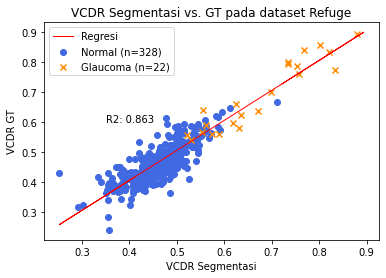

In [ ]:
abs_e = np.sum(abs(inf_df['VCDR GT'][50:]-inf_df['VCDR'][50:]))/ len(inf_df['VCDR'][50:])
xo = inf_df.loc[inf_df['tag']=='Normal']['VCDR'][50:]
yo = inf_df.loc[inf_df['tag']=='Normal']['VCDR GT'][50:]
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR'][50:]
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR GT'][50:]
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))

x = inf_df['VCDR'].to_numpy().reshape(-1, 1)
y = inf_df['VCDR GT'].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=1)
plt.ylabel('VCDR GT')
plt.xlabel('VCDR Segmentasi')
plt.title('VCDR Segmentasi vs. GT pada dataset Refuge')
plt.text(0.35, 0.6, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.03695
Absolute error in glaucoma cases: 0.03662
Absolute error in normal cases: 0.03568


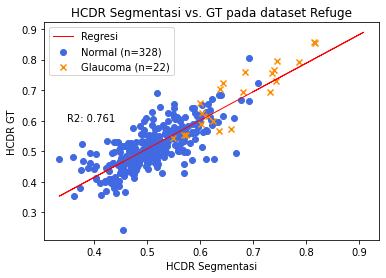

In [ ]:
abs_e = np.sum(abs(inf_df['HCDR GT'][50:]-inf_df['HCDR'][50:]))/ len(inf_df['HCDR'][50:])
xo = inf_df.loc[inf_df['tag']=='Normal']['HCDR'][50:]
yo = inf_df.loc[inf_df['tag']=='Normal']['HCDR GT'][50:]
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR'][50:]
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR GT'][50:]
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))

x = inf_df['HCDR'].to_numpy().reshape(-1, 1)
y = inf_df['HCDR GT'].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=1)
plt.ylabel('HCDR GT')
plt.xlabel('HCDR Segmentasi')
plt.title('HCDR Segmentasi vs. GT pada dataset Refuge')
plt.text(0.35, 0.6, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.02758
Absolute error in glaucoma cases: 0.02537
Absolute error in normal cases: 0.04081


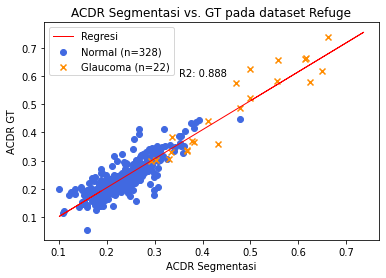

In [ ]:
abs_e = np.sum(abs(inf_df['ACDR GT'][50:]-inf_df['ACDR'][50:]))/ len(inf_df['ACDR'][50:])
xo = inf_df.loc[inf_df['tag']=='Normal']['ACDR'][50:]
yo = inf_df.loc[inf_df['tag']=='Normal']['ACDR GT'][50:]
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR'][50:]
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR GT'][50:]
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))

x = inf_df['ACDR'].to_numpy().reshape(-1, 1)
y = inf_df['ACDR GT'].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=1)
plt.ylabel('ACDR GT')
plt.xlabel('ACDR Segmentasi')
plt.title('ACDR Segmentasi vs. GT pada dataset Refuge')
plt.text(0.35, 0.6, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Fitur pada seluruh data

Absolute error in all cases: 0.03311
Absolute error in glaucoma cases: 0.03135
Absolute error in normal cases: 0.04238


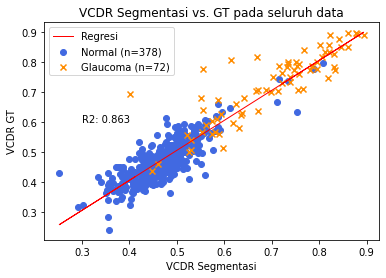

In [ ]:
abs_e = np.sum(abs(inf_df['VCDR GT']-inf_df['VCDR']))/ len(inf_df['VCDR'])
xo = inf_df.loc[inf_df['tag']=='Normal']['VCDR']
yo = inf_df.loc[inf_df['tag']=='Normal']['VCDR GT']
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR']
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR GT']
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))

x = inf_df['VCDR'].to_numpy().reshape(-1, 1)
y = inf_df['VCDR GT'].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=1)
plt.ylabel('VCDR GT')
plt.xlabel('VCDR Segmentasi')
plt.title('VCDR Segmentasi vs. GT pada seluruh data')
plt.text(0.3, 0.6, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.03835
Absolute error in glaucoma cases: 0.03698
Absolute error in normal cases: 0.04554


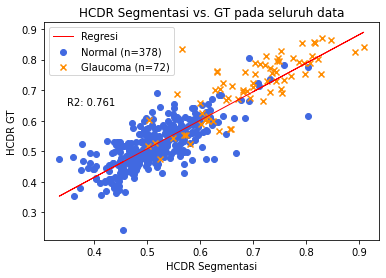

In [ ]:
abs_e = np.sum(abs(inf_df['HCDR GT']-inf_df['HCDR']))/ len(inf_df['HCDR'])
xo = inf_df.loc[inf_df['tag']=='Normal']['HCDR']
yo = inf_df.loc[inf_df['tag']=='Normal']['HCDR GT']
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR']
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR GT']
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))


x = inf_df['HCDR'].to_numpy().reshape(-1, 1)
y = inf_df['HCDR GT'].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=1)
plt.ylabel('HCDR GT')
plt.xlabel('HCDR Segmentasi')
plt.title('HCDR Segmentasi vs. GT pada seluruh data')
plt.text(0.35, 0.65, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.02986
Absolute error in glaucoma cases: 0.02610
Absolute error in normal cases: 0.04961


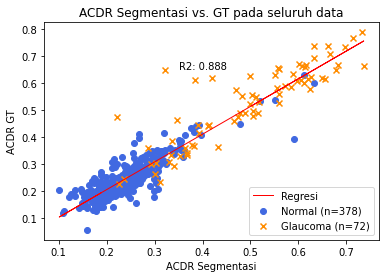

In [ ]:
abs_e = np.sum(abs(inf_df['ACDR GT']-inf_df['ACDR']))/ len(inf_df['ACDR'])
xo = inf_df.loc[inf_df['tag']=='Normal']['ACDR']
yo = inf_df.loc[inf_df['tag']=='Normal']['ACDR GT']
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR']
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR GT']
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))


x = inf_df['ACDR'].to_numpy().reshape(-1, 1)
y = inf_df['ACDR GT'].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=1)
plt.ylabel('ACDR GT')
plt.xlabel('ACDR Segmentasi')
plt.title('ACDR Segmentasi vs. GT pada seluruh data')
plt.text(0.35, 0.65, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

**Limit of Agreement**

GT number vs. GT mask

GT mask vs. Segmentation

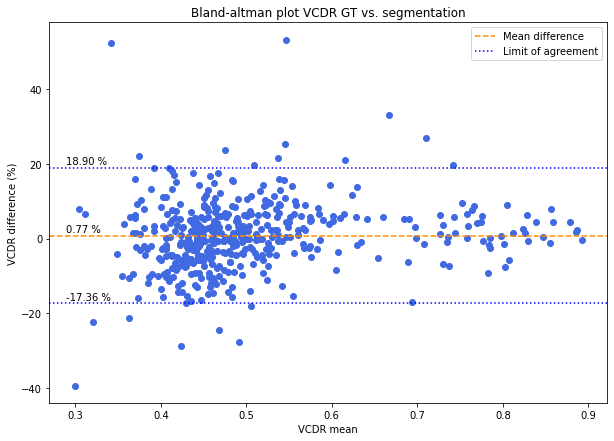

In [ ]:
val1 = inf_df['VCDR GT'].to_numpy()
val2 = inf_df['VCDR'].to_numpy()
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(10,7))
plt.scatter(rata2, diff_p, color='royalblue')
plt.axhline(mean, color = 'darkorange', linestyle = '--', label = 'Mean difference')
plt.axhline(mean + 1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(mean - 1.95*std, color = 'b', linestyle = ':')

plt.text(np.min(rata2) - 0.01, mean + 1, '{:.2f} %'.format(mean), size='medium')
plt.text(np.min(rata2)- 0.01, mean + 1.95*std  + 1, '{:.2f} %'.format(mean + 1.95*std), size='medium')
plt.text(np.min(rata2)- 0.01, mean - 1.95*std + 1, '{:.2f} %'.format(mean - 1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot VCDR GT vs. segmentation')
plt.ylabel('VCDR difference (%)')
plt.xlabel('VCDR mean')
plt.show()

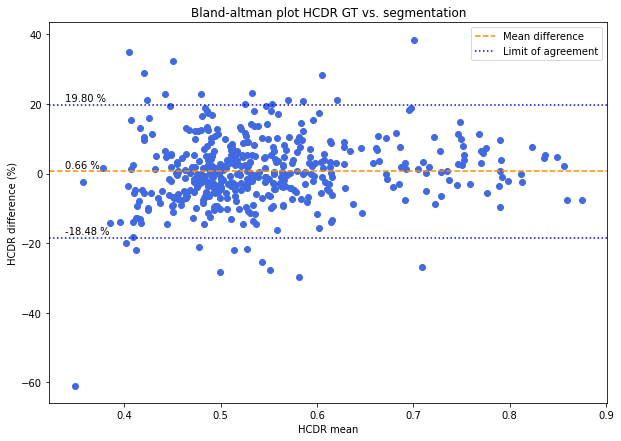

In [ ]:
val1 = inf_df['HCDR GT'].to_numpy()
val2 = inf_df['HCDR'].to_numpy()
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(10,7))
plt.scatter(rata2, diff_p, color='royalblue')
plt.axhline(mean, color = 'darkorange', linestyle = '--', label = 'Mean difference')
plt.axhline(mean + 1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(mean - 1.95*std, color = 'b', linestyle = ':')

plt.text(np.min(rata2) - 0.01, mean + 1, '{:.2f} %'.format(mean), size='medium')
plt.text(np.min(rata2)- 0.01, mean + 1.95*std  + 1, '{:.2f} %'.format(mean + 1.95*std), size='medium')
plt.text(np.min(rata2)- 0.01, mean - 1.95*std + 1, '{:.2f} %'.format(mean - 1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot HCDR GT vs. segmentation')
plt.ylabel('HCDR difference (%)')
plt.xlabel('HCDR mean')
plt.show()

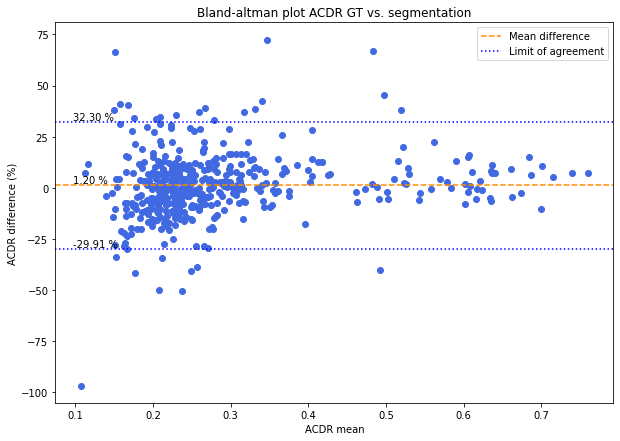

In [ ]:
val1 = inf_df['ACDR GT'].to_numpy()
val2 = inf_df['ACDR'].to_numpy()
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(10,7))
plt.scatter(rata2, diff_p, color='royalblue')
plt.axhline(mean, color = 'darkorange', linestyle = '--', label = 'Mean difference')
plt.axhline(mean + 1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(mean - 1.95*std, color = 'b', linestyle = ':')

plt.text(np.min(rata2) - 0.01, mean + 1, '{:.2f} %'.format(mean), size='medium')
plt.text(np.min(rata2)- 0.01, mean + 1.95*std  + 1, '{:.2f} %'.format(mean + 1.95*std), size='medium')
plt.text(np.min(rata2)- 0.01, mean - 1.95*std + 1, '{:.2f} %'.format(mean - 1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot ACDR GT vs. segmentation')
plt.ylabel('ACDR difference (%)')
plt.xlabel('ACDR mean')
plt.show()

# Glaucoma Inference

In [ ]:
inf_df.groupby(['tag']).size()

tag
Glaucoma     72
Normal      378
dtype: int64

In [ ]:
def encoder(y):
  encoded = []
  for label in y:
    if label == 'Glaucoma':
      encoded.append(1)
    elif label == 'Normal':
      encoded.append(0)
  
  encoded = np.array(encoded)
  return encoded

In [ ]:
feature_columns = ['VCDR']
feature_columns_GT = ['VCDR GT']
tag_column = ['tag']

x1a= inf_df[['VCDR']].to_numpy()
x1b= inf_df[['HCDR']].to_numpy()
x1c= inf_df[['ACDR']].to_numpy()
x2a = inf_df[['VCDR', 'ACDR']].to_numpy()
x2b = inf_df[['VCDR', 'HCDR']].to_numpy()
x2c = inf_df[['ACDR', 'HCDR']].to_numpy()
x3 = inf_df[['VCDR', 'ACDR', 'HCDR']].to_numpy()

x_GT1a = inf_df[['VCDR GT']].to_numpy()
x_GT1b = inf_df[['HCDR GT']].to_numpy()
x_GT1c = inf_df[['ACDR GT']].to_numpy()
x_GT2a = inf_df[['VCDR GT', 'ACDR GT']].to_numpy()
x_GT2b = inf_df[['VCDR GT', 'HCDR GT']].to_numpy()
x_GT2c = inf_df[['ACDR GT', 'HCDR GT']].to_numpy()
x_GT3 = inf_df[['VCDR GT', 'ACDR GT', 'HCDR GT']].to_numpy()

y = inf_df['tag'].to_numpy()
y = encoder(y)

In [ ]:
train_ix, test_ix = index_shuffle(f=2)

In [ ]:
# optimasi hyperparameter
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf1a = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
clf1b = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
clf1c = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
clf2a = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
clf2b = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
clf2c = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
clf3 = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)

clf1a.fit(x_GT1a[train_ix], y[train_ix])
clf1b.fit(x_GT1b[train_ix], y[train_ix])
clf1c.fit(x_GT1c[train_ix], y[train_ix])
clf2a.fit(x_GT2a[train_ix], y[train_ix])
clf2b.fit(x_GT2b[train_ix], y[train_ix])
clf2c.fit(x_GT2c[train_ix], y[train_ix])
clf3.fit(x_GT3[train_ix], y[train_ix])

print('Logistic Regression 1a: ',clf1a.best_params_)
print('Logistic Regression 1b: ',clf1b.best_params_)
print('Logistic Regression 1c: ',clf1c.best_params_)
print('Logistic Regression 2a: ',clf2a.best_params_)
print('Logistic Regression 2b: ',clf2b.best_params_)
print('Logistic Regression 2c: ',clf2b.best_params_)
print('Logistic Regression 3: ',clf3.best_params_)


Logistic Regression 1a:  {'C': 100}
Logistic Regression 1b:  {'C': 100}
Logistic Regression 1c:  {'C': 100}
Logistic Regression 2a:  {'C': 10}
Logistic Regression 2b:  {'C': 10}
Logistic Regression 2c:  {'C': 10}
Logistic Regression 3:  {'C': 10}


In [ ]:
def metrik(tn, fp, fn, tp):
  acc = (tp + tn) / (tp + tn + fp + fn)
  sen = tp / (tp + fn)
  spe = tn / (tn + fp)
  f = 2*tp / (2*tp + fp + fn)
  youden = sen + spe - 1
  return acc, sen, spe, f, youden

def threshold_pred(CDRS, threshold=0.56):
  pred = []
  for CDR in CDRS:
    if CDR < threshold:
      pred.append(0)
    elif CDR >= threshold:
      pred.append(1)
  pred = np.array(pred)
  return pred

Threshold 1a: Acc = 0.899
Logistic 1a: Acc = 0.944
Logistic 2a: Acc = 0.944
Logistic 2b: Acc = 0.944
Logistic 3: Acc = 0.944



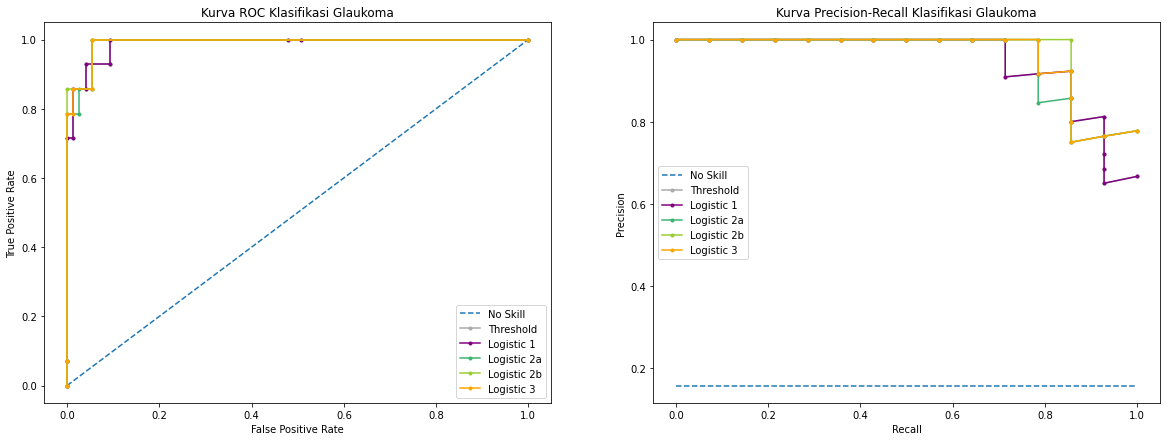

No Skill: ROC AUC=0.500
Logistic 1a: ROC AUC=0.989
Logistic 2a: ROC AUC=0.990
Logistic 2b: ROC AUC=0.992
Logistic 3: ROC AUC=0.991
Threshold 1a: ROC AUC=0.989
No Skill: PR AUC=0.157
Logistic 1a: PR AUC=0.950
Logistic 2a: PR AUC=0.956
Logistic 2b: PR AUC=0.966
Logistic 3: PR AUC=0.961
Threshold 1a: PR AUC=0.950


In [ ]:
# split into train/test sets
trainy = y[train_ix]
testy = y[test_ix]
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# fit a model
model1a = LogisticRegression(solver='lbfgs', C=100)
model2a = LogisticRegression(solver='lbfgs', C=10)
model2b = LogisticRegression(solver='lbfgs', C=10)
model3 = LogisticRegression(solver='lbfgs', C=10)

model1a.fit(x_GT1a[train_ix], trainy)
model2a.fit(x_GT2a[train_ix], trainy)
model2b.fit(x_GT2b[train_ix], trainy)
model3.fit(x_GT3[train_ix], trainy)

# predict probabilities
lr1a_probs = model1a.predict_proba(x_GT1a[test_ix])
lr2a_probs = model2a.predict_proba(x_GT2a[test_ix])
lr2b_probs = model2b.predict_proba(x_GT2b[test_ix])
lr3_probs = model3.predict_proba(x_GT3[test_ix])
# predict class

thd1a = threshold_pred(x_GT1a[test_ix], 0.56)
lr1a = model1a.predict(x_GT1a[test_ix])
lr2a = model2a.predict(x_GT2a[test_ix])
lr2b = model2b.predict(x_GT2b[test_ix])
lr3 = model3.predict(x_GT3[test_ix])

# Calculate accuracy
acc0a = accuracy_score(testy, thd1a)
acc1a = accuracy_score(testy, lr1a)
acc2a = accuracy_score(testy, lr2a)
acc2b = accuracy_score(testy, lr2b)
acc3 = accuracy_score(testy, lr3)

# summarize scores
print('Threshold 1a: Acc = %.3f' % (acc0a))
print('Logistic 1a: Acc = %.3f' % (acc1a))
print('Logistic 2a: Acc = %.3f' % (acc2a))
print('Logistic 2b: Acc = %.3f' % (acc2b))
print('Logistic 3: Acc = %.3f' % (acc3))
print()

# keep probabilities for the positive outcome only
lr1a_probs = lr1a_probs[:, 1]
lr2a_probs = lr2a_probs[:, 1]
lr2b_probs = lr2b_probs[:, 1]
lr3_probs = lr3_probs[:, 1]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr1a_fpr, lr1a_tpr, _ = roc_curve(testy, lr1a_probs)
lr2a_fpr, lr2a_tpr, _ = roc_curve(testy, lr2a_probs)
lr2b_fpr, lr2b_tpr, _ = roc_curve(testy, lr2b_probs)
lr3_fpr, lr3_tpr, _ = roc_curve(testy, lr3_probs)
cdra_fpr, cdra_tpr, _ = roc_curve(testy, x_GT1a[test_ix])

# calculate precision-recall curve
ns_precision, ns_recall, _ = precision_recall_curve(testy, ns_probs)
lr1a_precision, lr1a_recall, _ = precision_recall_curve(testy, lr1a_probs)
lr2a_precision, lr2a_recall, _ = precision_recall_curve(testy, lr2a_probs)
lr2b_precision, lr2b_recall, _ = precision_recall_curve(testy, lr2b_probs)
lr3_precision, lr3_recall, _ = precision_recall_curve(testy, lr3_probs)
cdra_precision, cdra_recall, _ = precision_recall_curve(testy, x_GT1a[test_ix])

# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr1a_auc = roc_auc_score(testy, lr1a_probs)
lr2a_auc = roc_auc_score(testy, lr2a_probs)
lr2b_auc = roc_auc_score(testy, lr2b_probs)
lr3_auc = roc_auc_score(testy, lr3_probs)
cdra_auc = roc_auc_score(testy, x_GT1a[test_ix])

# calculate scores
no_skill = len(testy[testy==1]) / len(testy)
lr1a_auc_pr = auc(lr1a_recall, lr1a_precision)
lr2a_auc_pr = auc(lr2a_recall, lr2a_precision)
lr2b_auc_pr = auc(lr2b_recall, lr2b_precision)
lr3_auc_pr = auc(lr3_recall, lr3_precision)
cdra_auc_pr = auc(cdra_recall,cdra_precision)


# plot the roc curve for the model
plt.figure(figsize=(20, 7))
plt.subplot(1,2,1),
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(cdra_fpr, cdra_tpr, marker='.', label='Threshold', color='darkgray')
plt.plot(lr1a_fpr, lr1a_tpr, marker='.', label='Logistic 1', color='purple')
plt.plot(lr2a_fpr, lr2a_tpr, marker='.', label='Logistic 2a', color='mediumseagreen')
plt.plot(lr2b_fpr, lr2b_tpr, marker='.', label='Logistic 2b', color='yellowgreen')
plt.plot(lr3_fpr, lr3_tpr, marker='.', label='Logistic 3', color='orange')
plt.title('Kurva ROC Klasifikasi Glaukoma')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# plot the PR curve for the model
plt.subplot(1,2,2),
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(cdra_recall, cdra_precision, marker='.', label='Threshold', color='darkgray')
plt.plot(lr1a_recall, lr1a_precision, marker='.', label='Logistic 1', color='purple')
plt.plot(lr2a_recall, lr2a_precision, marker='.', label='Logistic 2a', color='mediumseagreen')
plt.plot(lr2b_recall, lr2b_precision, marker='.', label='Logistic 2b', color='yellowgreen')
plt.plot(lr3_recall, lr3_precision, marker='.', label='Logistic 3', color='orange')
plt.title('Kurva Precision-Recall Klasifikasi Glaukoma')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()



# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic 1a: ROC AUC=%.3f' % (lr1a_auc))
print('Logistic 2a: ROC AUC=%.3f' % (lr2a_auc))
print('Logistic 2b: ROC AUC=%.3f' % (lr2b_auc))
print('Logistic 3: ROC AUC=%.3f' % (lr3_auc))
print('Threshold 1a: ROC AUC=%.3f' % (cdra_auc))

# summarize scores
print('No Skill: PR AUC=%.3f' % (no_skill))
print('Logistic 1a: PR AUC=%.3f' % (lr1a_auc_pr))
print('Logistic 2a: PR AUC=%.3f' % (lr2a_auc_pr))
print('Logistic 2b: PR AUC=%.3f' % (lr2b_auc_pr))
print('Logistic 3: PR AUC=%.3f' % (lr3_auc_pr))
print('Threshold 1a: PR AUC=%.3f' % (cdra_auc_pr))



In [ ]:
# predict class
thd1a = threshold_pred(x1a[test_ix])
#thd1b = threshold_pred(x1b[test_ix])
#thd1c = threshold_pred(x1c[test_ix])
lr1a = model1a.predict(x1a[test_ix])
#lr1b = model1b.predict(x1b[test_ix])
#lr1c = model1c.predict(x1c[test_ix])
lr2a = model2a.predict(x2a[test_ix])
lr2b = model2b.predict(x2b[test_ix])
#lr2c = model2c.predict(x2c[test_ix])
lr3 = model3.predict(x3[test_ix])

# Calculate accuracy
acc0a = accuracy_score(testy, thd1a)
#acc0b = accuracy_score(testy, thd1b)
#acc0c = accuracy_score(testy, thd1c)
acc1a = accuracy_score(testy, lr1a)
#acc1b = accuracy_score(testy, lr1b)
#acc1c = accuracy_score(testy, lr1c)
acc2a = accuracy_score(testy, lr2a)
acc2b = accuracy_score(testy, lr2b)
#acc2c = accuracy_score(testy, lr2c)
acc3 = accuracy_score(testy, lr3)

# summarize scores
print('Threshold 1a: Acc = %.3f' % (acc0a))
#print('Threshold 1b: Acc = %.3f' % (acc0b))
#print('Threshold 1c: Acc = %.3f' % (acc0c))
print('Logistic 1a: Acc = %.3f' % (acc1a))
#print('Logistic 1b: Acc = %.3f' % (acc1b))
#print('Logistic 1c: Acc = %.3f' % (acc1c))
print('Logistic 2a: Acc = %.3f' % (acc2a))
print('Logistic 2b: Acc = %.3f' % (acc2b))
#print('Logistic 2c: Acc = %.3f' % (acc2c))
print('Logistic 3: Acc = %.3f' % (acc3))
print()

Threshold 1a: Acc = 0.921
Logistic 1a: Acc = 0.888
Logistic 2a: Acc = 0.876
Logistic 2b: Acc = 0.876
Logistic 3: Acc = 0.876



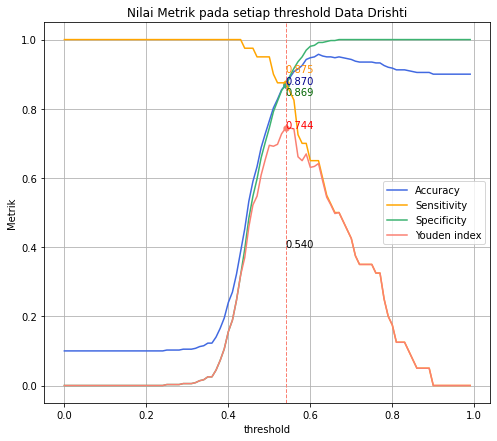

In [ ]:
X = x_GT1a[50:]
#model = model3
y_true = y[50:]
thresholds = []
acc = []
sen = []
spe = []
youd = []
for i in range(100):
  thd = i*0.01
  #pred = model.predict_proba(X)
  y_pred = threshold_pred(X, threshold=thd)
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc1, sen1, spe1, f1, youden = metrik(tn, fp, fn, tp)
  thresholds.append(thd)
  sen.append(sen1)
  spe.append(spe1)
  acc.append(acc1)
  youd.append(youden)
X = thresholds
y1 = acc
y2 = sen
y3 = spe
y4 = youd
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
max_youd = np.max(y4)
t_youd = X[y4.index(max_youd)]
idx = X.index(t_youd)
max_acc = y1[idx]
max_sen = y2[idx]
max_spe = y3[idx]


ax.plot(X, y1, color='royalblue', label='Accuracy')
ax.plot(X, y2, color='orange', label='Sensitivity')
ax.plot(X, y3, color='mediumseagreen', label='Specificity')
ax.plot(X, y4, color='salmon', label='Youden index')
ax.scatter(t_youd, max_acc, marker='o', color='royalblue', lw=0.25)
ax.scatter(t_youd, max_sen, marker='o', color='orange', lw=0.25)
ax.scatter(t_youd, max_spe, marker='o', color='mediumseagreen', lw=0.25)
ax.scatter(t_youd, max_youd, marker='o', color='salmon', lw=0.25)

ax.axvline(x=t_youd, linestyle='--', color='salmon', lw=1)

ax.text(t_youd, 0.4, '{:.3f}'.format(t_youd), size='medium')
ax.set_xlabel('threshold')
ax.set_ylabel('Metrik')
ax.text(t_youd, max_acc, '{:.3f}'.format(max_acc), size='medium', color='darkblue')
ax.text(t_youd, max_sen+0.03, '{:.3f}'.format(max_sen), size='medium', color='darkorange')
ax.text(t_youd, max_spe-0.03, '{:.3f}'.format(max_spe), size='medium', color='darkgreen')
ax.text(t_youd, max_youd, '{:.3f}'.format(max_youd), size='medium', color='red')
ax.grid()
ax.set_title('Nilai Metrik pada setiap threshold Data Drishti')
ax.legend()
plt.show()

In [ ]:
def plot_cfm(cfm, ax, i, metode):
  im = ax[i].imshow(cfm, cmap='summer')
  classes = ['Normal', 'Glaucoma']
  # We want to show all ticks...
  ax[i].set_xticks(np.arange(len(classes)))
  ax[i].set_yticks(np.arange(len(classes)))
  # ... and label them with the respective list entries
  ax[i].set_xticklabels(classes)
  ax[i].set_yticklabels(classes)
  ax[i].set_xlabel('Prediksi')
  ax[i].set_ylabel('Label')
  # Rotate the tick labels and set their alignment.
  plt.setp(ax[i].get_yticklabels(), rotation=90, ha="center",
          rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  for x in range(len(classes)):
      for y in range(len(classes)):
          text = ax[i].text(y, x, cfm[x, y],
                        ha="center", va="center", color="k", size='x-large')

  ax[i].set_title("Confusion Matrix {}".format(metode))

# Confusion matrix
def confusion_m(y_pred, y_true, partial=False, ix=None):
  drishti = list(range(50))
  refuge = list(range(50, 450))
  if partial:  
    ix_drishti = list(set(ix).intersection(drishti))
    ix_refuge = list(set(ix).intersection(refuge))
    idx = ix

  else:
    ix_drishti = drishti
    ix_refuge = refuge
    idx = drishti+refuge
  cfm1 = confusion_matrix(y_true[idx], y_pred[idx])
  cfm2 = confusion_matrix(y_true[ix_drishti], y_pred[ix_drishti])
  cfm3 = confusion_matrix(y_true[ix_refuge], y_pred[ix_refuge])
  tn1, fp1, fn1, tp1 = cfm1.ravel()
  tn2, fp2, fn2, tp2 = cfm2.ravel()
  tn3, fp3, fn3, tp3 = cfm3.ravel()
  acc1, sen1, spe1, f1, _ = metrik(tn1, fp1, fn1, tp1)
  acc2, sen2, spe2, f2, _ = metrik(tn2, fp2, fn2, tp2)
  acc3, sen3, spe3, f3, _ = metrik(tn3, fp3, fn3, tp3)
  
  
  fig, ax = plt.subplots(1,3, figsize=(12, 4))
  plot_cfm(cfm1, ax, 0, metode='Seluruh Data')
  plot_cfm(cfm2, ax, 1, metode='Drishti')
  plot_cfm(cfm3, ax, 2, metode='Refuge')
  fig.tight_layout()
  plt.show()
  print('Seluruh data  | Drishti      | Refuge')
  print('Acc 1: {:.3f}  | Acc 2: {:.3f} | Acc 3: {:.3f}'.format(acc1, acc2, acc3))
  print('Sen 1: {:.3f}  | Sen 2: {:.3f} | Sen 3: {:.3f}'.format(sen1, sen2, sen3))
  print('Spe 1: {:.3f}  | Spe 2: {:.3f} | Spe 3: {:.3f}'.format(spe1, spe2, spe3))
  print('F1   : {:.3f}  | F2   : {:.3f} | F3   : {:.3f}'.format(f1, f2, f3))

Thresholding


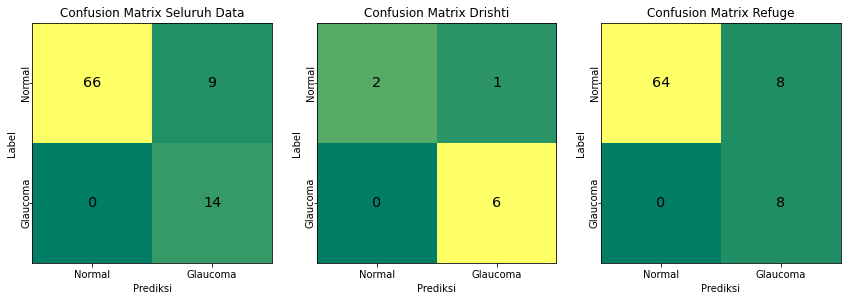

Seluruh data  | Drishti      | Refuge
Acc 1: 0.899  | Acc 2: 0.889 | Acc 3: 0.900
Sen 1: 1.000  | Sen 2: 1.000 | Sen 3: 1.000
Spe 1: 0.880  | Spe 2: 0.667 | Spe 3: 0.889
F1   : 0.757  | F2   : 0.923 | F3   : 0.667
LR 1


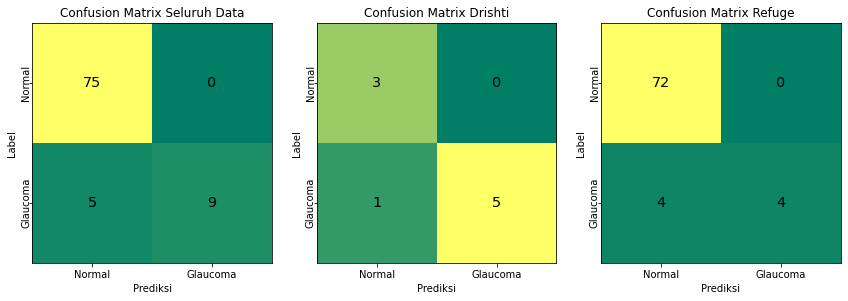

Seluruh data  | Drishti      | Refuge
Acc 1: 0.944  | Acc 2: 0.889 | Acc 3: 0.950
Sen 1: 0.643  | Sen 2: 0.833 | Sen 3: 0.500
Spe 1: 1.000  | Spe 2: 1.000 | Spe 3: 1.000
F1   : 0.783  | F2   : 0.909 | F3   : 0.667
LR 2a


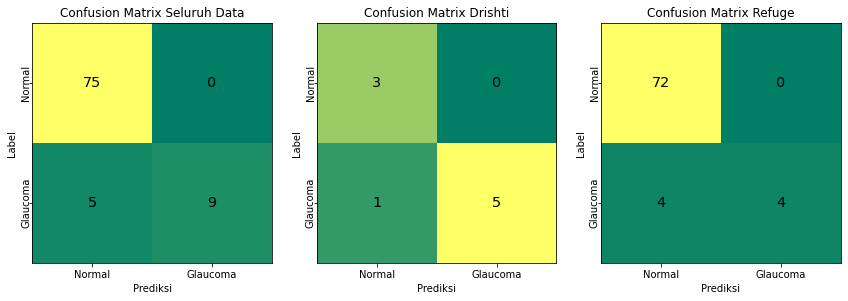

Seluruh data  | Drishti      | Refuge
Acc 1: 0.944  | Acc 2: 0.889 | Acc 3: 0.950
Sen 1: 0.643  | Sen 2: 0.833 | Sen 3: 0.500
Spe 1: 1.000  | Spe 2: 1.000 | Spe 3: 1.000
F1   : 0.783  | F2   : 0.909 | F3   : 0.667
LR 2b


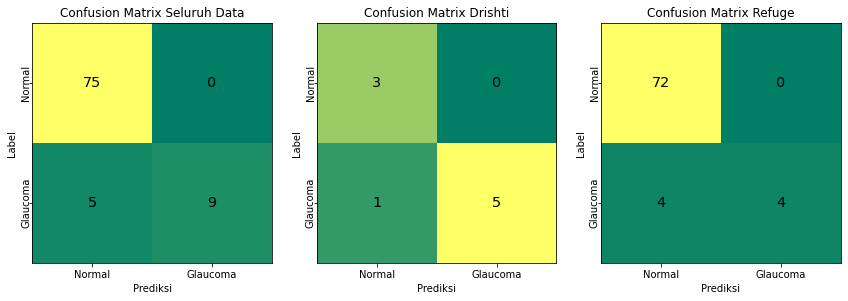

Seluruh data  | Drishti      | Refuge
Acc 1: 0.944  | Acc 2: 0.889 | Acc 3: 0.950
Sen 1: 0.643  | Sen 2: 0.833 | Sen 3: 0.500
Spe 1: 1.000  | Spe 2: 1.000 | Spe 3: 1.000
F1   : 0.783  | F2   : 0.909 | F3   : 0.667
LR 3


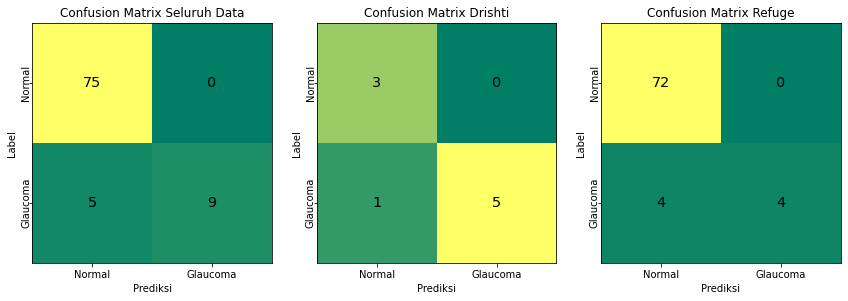

Seluruh data  | Drishti      | Refuge
Acc 1: 0.944  | Acc 2: 0.889 | Acc 3: 0.950
Sen 1: 0.643  | Sen 2: 0.833 | Sen 3: 0.500
Spe 1: 1.000  | Spe 2: 1.000 | Spe 3: 1.000
F1   : 0.783  | F2   : 0.909 | F3   : 0.667


In [ ]:
print('Thresholding')
y_pred = threshold_pred(x_GT1a, threshold=0.56)
y_true = y
confusion_m(y_pred, y_true, partial=True, ix=test_ix)

print('LR 1')
y_pred = model1a.predict(x_GT1a)
confusion_m(y_pred, y_true, partial=True, ix=test_ix)

print('LR 2a')
y_pred = model2a.predict(x_GT2a)
confusion_m(y_pred, y_true, partial=True, ix=test_ix)

print('LR 2b')
y_pred = model2b.predict(x_GT2b)
confusion_m(y_pred, y_true, partial=True, ix=test_ix)

print('LR 3')
y_pred = model3.predict(x_GT3)
confusion_m(y_pred, y_true, partial=True, ix=test_ix)